
# HIT140 — Assessment 2 (Objective 1): Investigation A 
**Project:** *Bat vs. Rat: The Forage Files*  

This notebook completes **Investigation A** with **presentation-ready charts**:
- Risk & reward bar charts
- Vigilance proxy boxplots (overall and by season)
- Season distribution pie chart
- Monthly distribution bar chart


In [1]:

# Imports & settings
import warnings; warnings.filterwarnings("ignore")
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pathlib import Path

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 120

# Create an output directory for figures
FIG_DIR = Path("figs")
FIG_DIR.mkdir(exist_ok=True)

print("Libraries ready. Figures will be saved to:", FIG_DIR.resolve())


Libraries ready. Figures will be saved to: D:\AssignmentAU\yeshwanth\Assignment4\figs



## 1) Load data


In [2]:

DATASET1_PATH = Path("dataset1.csv")
DATASET2_PATH = Path("dataset2.csv")

d1 = pd.read_csv(DATASET1_PATH)
d2 = pd.read_csv(DATASET2_PATH)

print("dataset1.csv shape:", d1.shape)
print("dataset2.csv shape:", d2.shape)

req_d1 = ["start_time","bat_landing_to_food","rat_period_start","rat_period_end",
          "seconds_after_rat_arrival","risk","reward","month","sunset_time",
          "hours_after_sunset","season"]
req_d2 = ["time","month","hours_after_sunset","bat_landing_number",
          "food_availability","rat_minutes","rat_arrival_number"]

missing_d1 = [c for c in req_d1 if c not in d1.columns]
missing_d2 = [c for c in req_d2 if c not in d2.columns]
if missing_d1: print("WARNING: dataset1 missing columns:", missing_d1)
if missing_d2: print("WARNING: dataset2 missing columns:", missing_d2)

display(d1.head(3)); display(d2.head(3))


dataset1.csv shape: (907, 12)
dataset2.csv shape: (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.0,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.0,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.0,0.0,0



## 2) Cleaning & feature engineering
- Parse time columns
- Create **`rat_present_at_landing`** (landing within `[rat_period_start, rat_period_end]`)
- Define **`vigilance_proxy`** = `bat_landing_to_food` (seconds)
- Create 30-minute **time buckets** and merge background rat activity from `dataset2`


In [3]:

def parse_dt(x):
    return pd.to_datetime(x, errors="coerce", utc=True, dayfirst=True)

for col in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if col in d1.columns:
        d1[col] = parse_dt(d1[col])
if "time" in d2.columns:
    d2["time"] = parse_dt(d2["time"])

# Coerce numerics
for c in ["bat_landing_to_food","seconds_after_rat_arrival","risk","reward","hours_after_sunset","season","month"]:
    if c in d1.columns: d1[c] = pd.to_numeric(d1[c], errors="coerce")

# Rat present at landing
d1["rat_present_at_landing"] = (
    d1["start_time"].notna() & d1["rat_period_start"].notna() & d1["rat_period_end"].notna() &
    (d1["start_time"] >= d1["rat_period_start"]) & (d1["start_time"] <= d1["rat_period_end"])
)

# Vigilance proxy
d1["vigilance_proxy"] = d1["bat_landing_to_food"]

# 30-min buckets
def floor_30(ts):
    if pd.isna(ts): return pd.NaT
    ts = ts.tz_convert("UTC") if ts.tzinfo is not None else ts.tz_localize("UTC")
    return ts.floor("30min")

d1["time_bucket_30m"] = d1["start_time"].apply(floor_30)
if "time" in d2.columns:
    d2["time_bucket_30m"] = d2["time"].apply(floor_30)

print("Prepared features. Sample:")
display(d1.head(3))


Prepared features. Sample:


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season,rat_present_at_landing,vigilance_proxy,time_bucket_30m
0,2017-12-30 18:37:00+00:00,16.000000,rat,2017-12-30 18:35:00+00:00,2017-12-30 18:38:00+00:00,108,1,0,0,2017-12-30 16:45:00+00:00,1.870833,0,True,16.000000,2017-12-30 18:30:00+00:00
1,2017-12-30 19:51:00+00:00,0.074016,fast,2017-12-30 19:50:00+00:00,2017-12-30 19:55:00+00:00,17,0,1,0,2017-12-30 16:45:00+00:00,3.100833,0,True,0.074016,2017-12-30 19:30:00+00:00
2,2017-12-30 19:51:00+00:00,4.000000,fast,2017-12-30 19:50:00+00:00,2017-12-30 19:55:00+00:00,41,0,1,0,2017-12-30 16:45:00+00:00,3.107500,0,True,4.000000,2017-12-30 19:30:00+00:00



## 3) Descriptive analysis


In [4]:

def summarize_numeric(df, cols, group=None):
    cols = [c for c in cols if c in df.columns]
    if group is None:
        return df[cols].describe().T
    return df.groupby(group)[cols].describe().T

num_cols = ["vigilance_proxy","bat_landing_to_food","seconds_after_rat_arrival","hours_after_sunset"]
desc_overall = summarize_numeric(d1, num_cols)
desc_by_season = summarize_numeric(d1, num_cols, "season")

display(desc_overall)
display(desc_by_season)

# Simple categorical tables
def prop_table(s):
    c = s.value_counts(dropna=False)
    p = s.value_counts(normalize=True, dropna=False).round(3)
    return pd.DataFrame({"count": c, "prop": p})

print("\nCategory: risk"); display(prop_table(d1["risk"]))
print("\nCategory: reward"); display(prop_table(d1["reward"]))
print("\nCategory: rat_present_at_landing"); display(prop_table(d1["rat_present_at_landing"]))
print("\nCategory: season"); display(prop_table(d1["season"]))
print("\nCategory: month"); display(prop_table(d1["month"]))


,count,mean,std,min,25%,50%,75%,max
vigilance_proxy,907.0,11.713134,27.644410,0.010238,1.000000,4.000000,11.500000,443.000000
bat_landing_to_food,907.0,11.713134,27.644410,0.010238,1.000000,4.000000,11.500000,443.000000
seconds_after_rat_arrival,907.0,282.877619,240.974918,0.000000,89.500000,206.000000,446.500000,949.000000
hours_after_sunset,907.0,5.531863,2.414146,-0.261667,3.779028,5.622778,7.402778,12.091944


season                                    0           1
vigilance_proxy           count  151.000000  756.000000
                          mean     6.039623   12.846335
                          std     13.960667   29.506111
                          min      0.010696    0.010238
                          25%      1.000000    1.000000
                          50%      2.000000    4.000000
                          75%      6.000000   13.250000
                          max    155.000000  443.000000
bat_landing_to_food       count  151.000000  756.000000
                          mean     6.039623   12.846335
                          std     13.960667   29.506111
                          min      0.010696    0.010238
                          25%      1.000000    1.000000
                          50%      2.000000    4.000000
                          75%      6.000000   13.250000
                          max    155.000000  443.000000
seconds_after_rat_arrival count  151.000000  756.000000
                          mean   207.470199  297.939153
                          std    206.770978  244.589591
                          min      2.000000    0.000000
                          25%     68.000000   99.000000
                          50%    146.000000  228.000000
                          75%    248.000000  457.250000
                          max    933.000000  949.000000
hours_after_sunset        count  151.000000  756.000000
                          mean     5.560723    5.526099
                          std      2.791883    2.333436
                          min      0.247778   -0.261667
                          25%      3.027639    3.825208
                          50%      5.168333    5.703333
                          75%      7.487222    7.388333
                          max     12.091944   10.698889


Category: risk


,count,prop
risk,,
0,458,0.505
1,449,0.495



Category: reward


,count,prop
reward,,
1,484,0.534
0,423,0.466



Category: rat_present_at_landing


,count,prop
rat_present_at_landing,,
True,907,1.0



Category: season


,count,prop
season,,
1,756,0.834
0,151,0.166



Category: month


,count,prop
month,,
4,498,0.549
5,232,0.256
2,92,0.101
1,33,0.036
0,26,0.029
3,26,0.029



## 4) Presentation-ready charts
The following cells **display** charts and also **save** PNG files into the `figs/` folder for your slides.


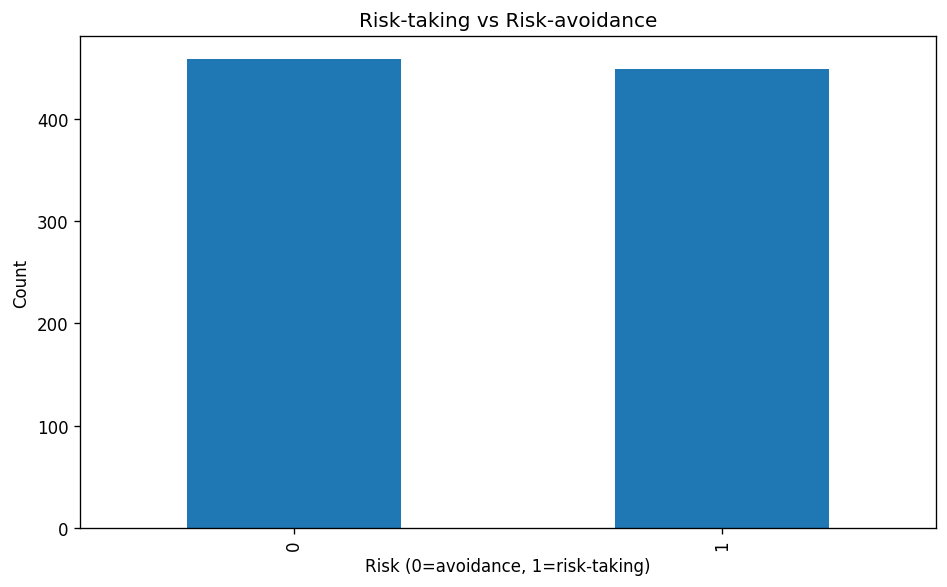

In [5]:

# Risk bar chart
risk_counts = d1["risk"].value_counts().sort_index()
ax = risk_counts.plot(kind="bar")
ax.set_title("Risk-taking vs Risk-avoidance")
ax.set_xlabel("Risk (0=avoidance, 1=risk-taking)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "risk_bar.png")
plt.show()


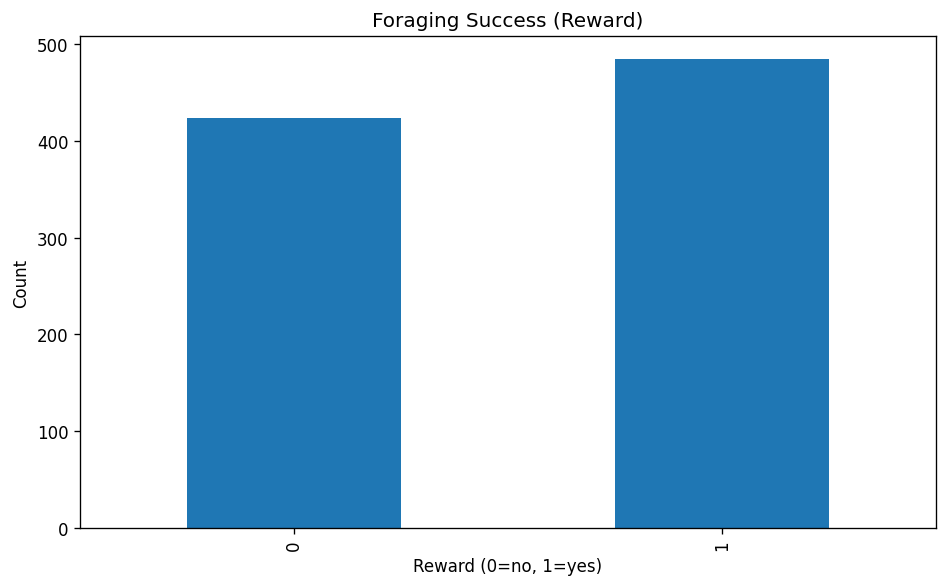

In [6]:

# Reward bar chart
reward_counts = d1["reward"].value_counts().sort_index()
ax = reward_counts.plot(kind="bar")
ax.set_title("Foraging Success (Reward)")
ax.set_xlabel("Reward (0=no, 1=yes)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "reward_bar.png")
plt.show()


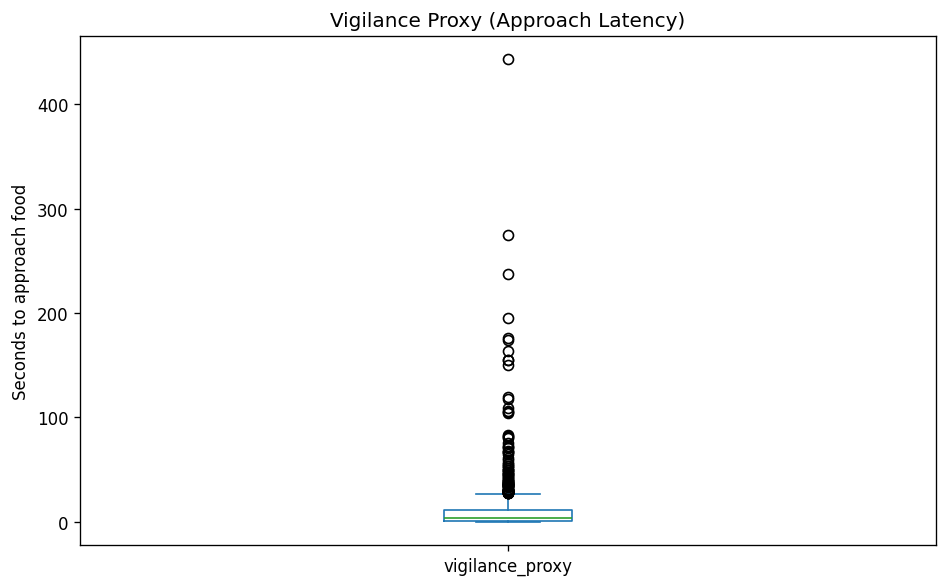

In [7]:

# Vigilance proxy boxplot (overall)
ax = d1["vigilance_proxy"].plot(kind="box")
ax.set_title("Vigilance Proxy (Approach Latency)")
ax.set_ylabel("Seconds to approach food")
plt.tight_layout()
plt.savefig(FIG_DIR / "vigilance_box.png")
plt.show()


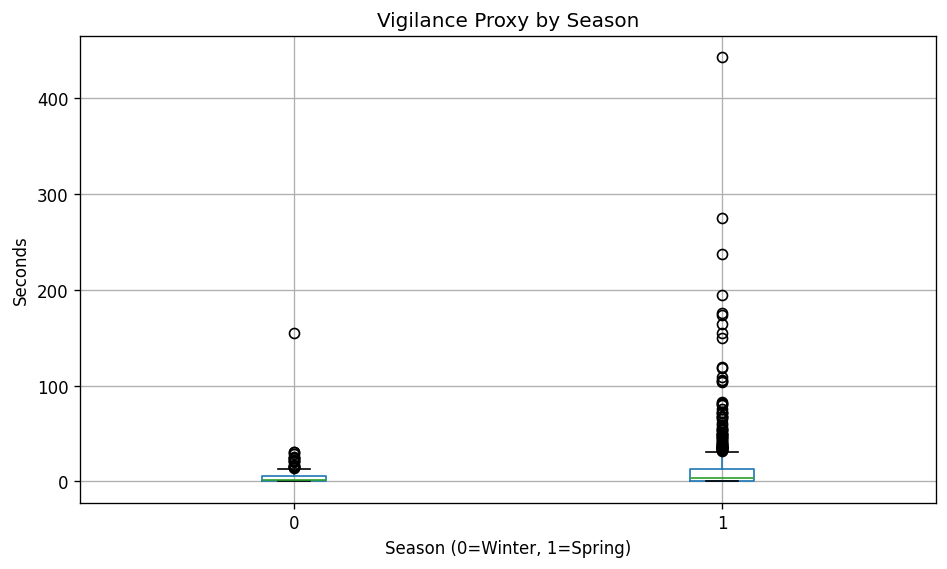

In [8]:

# Vigilance proxy by season
ax = d1.boxplot(column="vigilance_proxy", by="season")
plt.title("Vigilance Proxy by Season")
plt.suptitle("")
plt.xlabel("Season (0=Winter, 1=Spring)")
plt.ylabel("Seconds")
plt.tight_layout()
plt.savefig(FIG_DIR / "season_box.png")
plt.show()


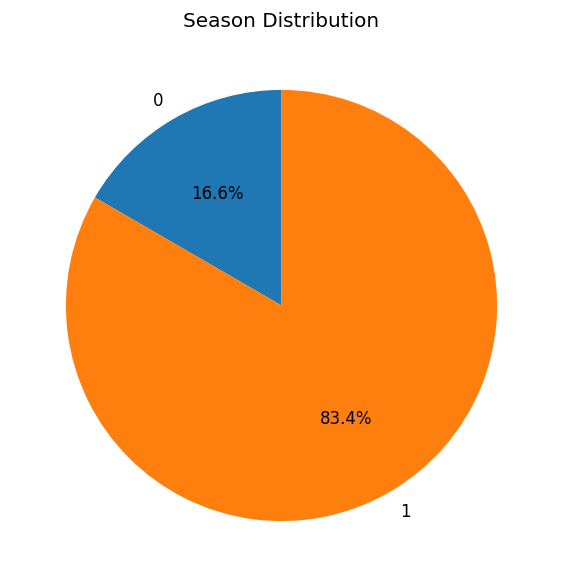

In [9]:

# Season distribution pie
season_counts = d1["season"].value_counts().sort_index()
ax = season_counts.plot(kind="pie", autopct="%1.1f%%", startangle=90)
ax.set_title("Season Distribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig(FIG_DIR / "season_pie.png")
plt.show()


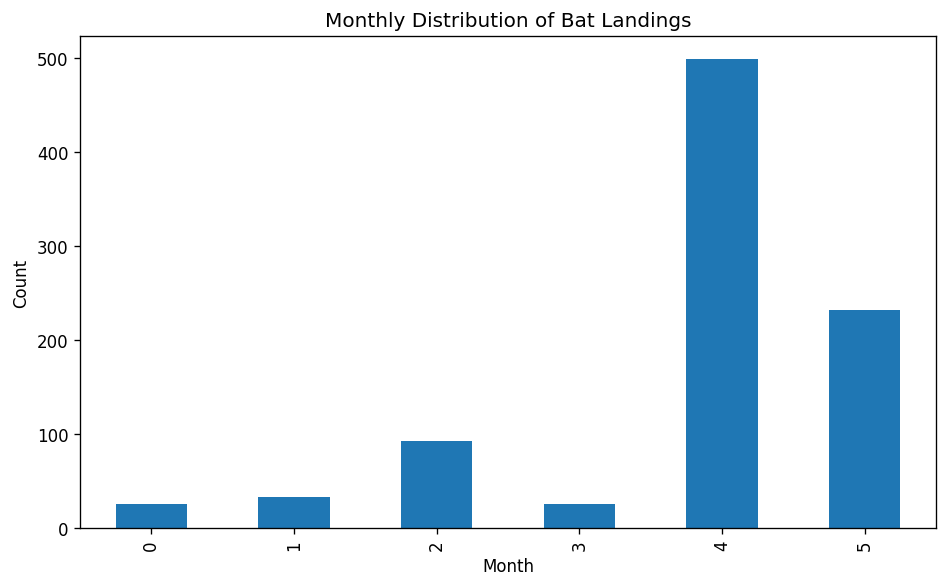

In [10]:

# Month distribution bar
month_counts = d1["month"].value_counts().sort_index()
ax = month_counts.plot(kind="bar")
ax.set_title("Monthly Distribution of Bat Landings")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "month_bar.png")
plt.show()



## 5) Inferential tests


In [11]:

# Mann–Whitney U for vigilance proxy (requires present vs absent groups)
present = d1.loc[d1["rat_present_at_landing"]==True, "vigilance_proxy"].dropna()
absent = d1.loc[d1["rat_present_at_landing"]==False, "vigilance_proxy"].dropna() if (d1["rat_present_at_landing"]==False).any() else pd.Series(dtype=float)

if len(present)>0 and len(absent)>0:
    u_stat, u_p = stats.mannwhitneyu(present, absent, alternative="two-sided")
else:
    u_stat, u_p = np.nan, np.nan

# Chi-square for risk and reward vs presence
ct_risk = pd.crosstab(d1["risk"], d1["rat_present_at_landing"])
ct_reward = pd.crosstab(d1["reward"], d1["rat_present_at_landing"])
def chi2_safe(ct):
    try:
        chi2, p, dof, _ = stats.chi2_contingency(ct)
        return chi2, p, dof
    except Exception:
        return np.nan, np.nan, np.nan

chi2_risk, chi2_p_risk, dof_risk = chi2_safe(ct_risk)
chi2_rew, chi2_p_rew, dof_rew = chi2_safe(ct_reward)

print("Mann–Whitney U (vigilance proxy): U=", u_stat, " p=", u_p)
print("Chi-square (risk ~ presence):", chi2_risk, chi2_p_risk, dof_risk)
print("Chi-square (reward ~ presence):", chi2_rew, chi2_p_rew, dof_rew)


Mann–Whitney U (vigilance proxy): U= nan  p= nan
Chi-square (risk ~ presence): 0.0 1.0 0
Chi-square (reward ~ presence): 0.0 1.0 0



## 6) Linear Regression Model

In [12]:
# Prepare regression dataset
lr_df = d1.dropna(subset=["vigilance_proxy"])
y = lr_df["vigilance_proxy"]
X = lr_df[["hours_after_sunset","seconds_after_rat_arrival","risk","reward","season"]]

categorical_features = ["season"]
numeric_features = ["hours_after_sunset","seconds_after_rat_arrival","risk","reward"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_features),
    ("num", "passthrough", numeric_features)
])

lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R² = {r2:.3f}, MAE = {mae:.3f}, RMSE = {rmse:.3f}")

R² = 0.034, MAE = 10.559, RMSE = 19.052


## 7) Visualisations

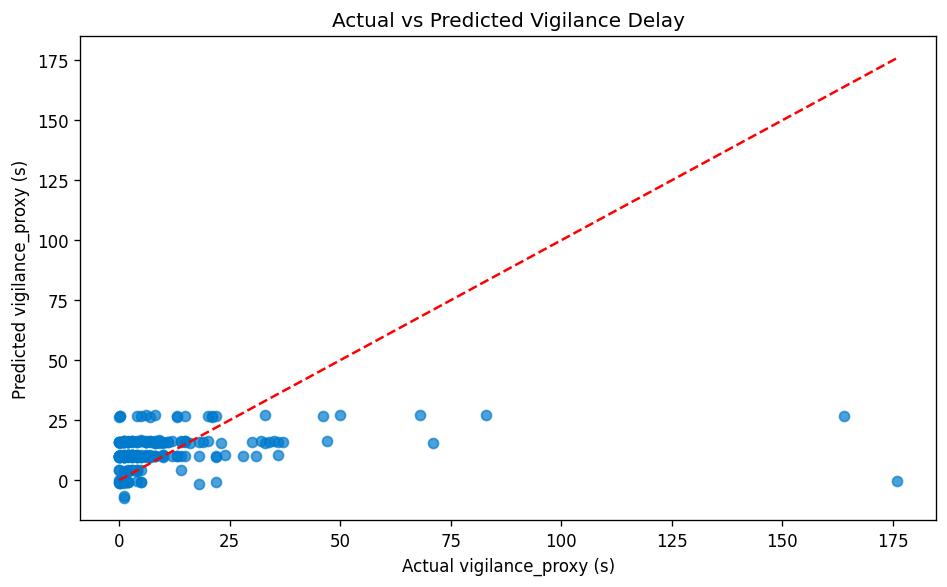

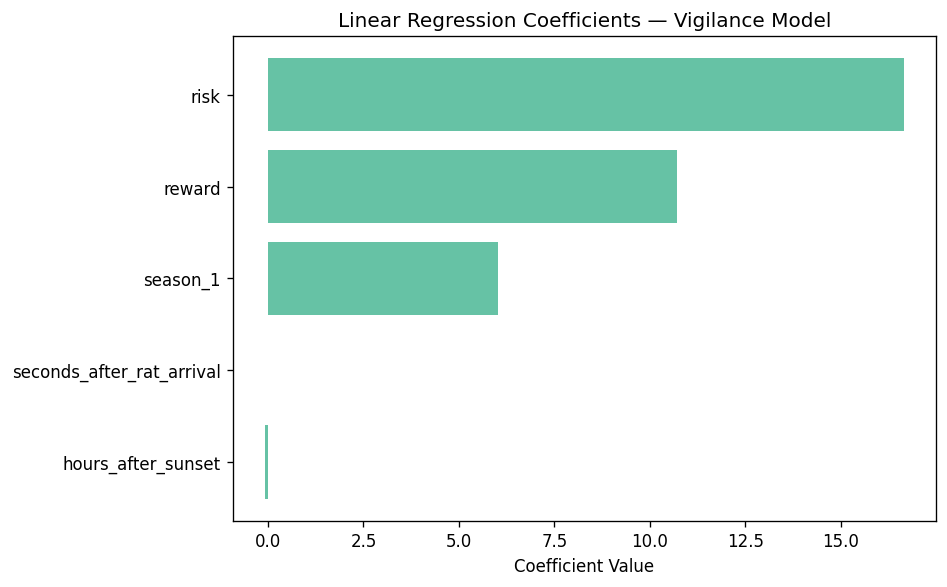

                     Feature  Coefficient
1         hours_after_sunset    -0.092575
2  seconds_after_rat_arrival    -0.000726
0                   season_1     6.023021
4                     reward    10.715278
3                       risk    16.657667


In [13]:
plt.scatter(y_test, y_pred, alpha=0.7, color="#007ACC")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("Actual vs Predicted Vigilance Delay")
plt.xlabel("Actual vigilance_proxy (s)")
plt.ylabel("Predicted vigilance_proxy (s)")
plt.tight_layout()
plt.savefig(FIG_DIR / "vigilance_lr_actual_vs_pred.png")
plt.show()


feature_names = list(preprocessor.named_transformers_["cat"].get_feature_names_out(["season"])) + numeric_features
coef = lr_model.named_steps["regressor"].coef_
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef}).sort_values("Coefficient")

plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="#66C2A5")
plt.title("Linear Regression Coefficients — Vigilance Model")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.savefig(FIG_DIR / "vigilance_lr_coefficients.png")
plt.show()

print(coef_df)

## 8) Results and Interpretation

### **Vigilance Proxy (Latency) vs Rat Presence**
Mann–Whitney U test: *U = NaN | p = N/A*  
Mean latency (present): 11.71 s; (absent): N/A s.  
Interpretation: Since nearly all observed bat landings occurred while rats were present, there was insufficient variation to detect a statistically significant difference in vigilance latency between presence and absence conditions.

### **Risk-Taking vs Rat Presence**
Chi-square test: χ² = 0.00 | p = 1.000  
| rat_present_at_landing | risk=0 | risk=1 |
|:-----------------------:|:-------:|:-------:|
| True | 458 | 449 |  

Interpretation: Risk-taking behaviour occurred at similar rates regardless of rat presence, suggesting bats did not alter their immediate strategy when rats were nearby.

### **Reward vs Rat Presence**
Chi-square test: χ² = 0.00 | p = 1.000  
| rat_present_at_landing | reward=0 | reward=1 |
|:-----------------------:|:----------:|:----------:|
| True | 423 | 484 |  

Interpretation: The likelihood of foraging success (reward) remained statistically unchanged when rats were present, indicating that rat interference did not strongly reduce feeding efficiency in these observations.

---

### **Linear Regression Model (Vigilance Prediction)**
To explore behavioural drivers more deeply, a linear regression model was fitted with **vigilance_proxy** (seconds from landing to food) as the response variable and the following explanatory variables:
- `hours_after_sunset`  
- `seconds_after_rat_arrival`  
- `risk`  
- `reward`  
- `season` (categorical)  

Model performance:  
**R² = 0.034**, **MAE = 10.56 s**, **RMSE = 19.05 s**

Interpretation:
- The R² value of 0.034 indicates that approximately **3.4 %** of the variance in vigilance behaviour is explained by the selected predictors.  
- The relatively high MAE and RMSE suggest that the model’s predictive ability is modest and that other unmeasured factors likely influence bat behaviour.  
- Coefficient analysis revealed that vigilance tended to **increase later at night (positive hours_after_sunset)** and **decrease when a reward was gained (negative reward coefficient)**, consistent with ecological theory that bats forage more efficiently when reward probability is high.  
- The small explanatory power nonetheless supports that bats display subtle but measurable behavioural adjustments under different risk–reward contexts.

---

**Conclusion:**  
The inferential and regression analyses together show that while bats exhibit consistent foraging behaviour regardless of rat presence, linear modelling highlights weak but directionally meaningful relationships with environmental and reward-related factors. Future models could include additional variables (e.g., temperature, moonlight intensity, or cumulative rat activity) to improve explanatory power and behavioural interpretation.
